Reflections

Algorithm: 
Using the approach from lectures as a baseline, with the following differences:
* Using YUV colorspace in order to better / easier detect Yellow and White lanes. This allows to better segment bright lines.
* Instead of using lecture function hough_lines, whote custom function process_image_yuv_weighted, that detects probablistic hough lines (same as in lecture), but after that:
a) Merges the individual lines using the weighted average of already merged lines with the new line. That way it is possible to avoid multiple smaller lines and also in the future use the weight of the line to identify the most probable lane lines.
b) Draws only lines that has realistic scope for the lane lines, i.e does not draw the lines which are inside of the region of interest, but has 'wrong' slope.


Thoughts of lane finding algorithm:
- Initial approach of RGB space and standard hough lines worked quite well in initial set of images / videos. Switching to yellow lines and especailly brighter light / road in challenge set required investigation how to make it more robust, that lead to switching to YUV colorspace.

- Another challenge was that for the thicker lines hough detects multiple lines with similar slope and also this appears more of an issue with segmented lines, therefore I wrote additional function that merges the found lines using the weighted average for slope and intercept (m and b).


How to make algorithm better / robust:
- In order to make it robust, would need to obtain additional input data, with varying weather / light / road conditions and see in which locations it is failing. And based on those cases, improve the reliability of the algorithm.


Where will your current algorithm be likely to fail:
- Curved roads - would need to use either curve detection algorithms or adjust for the perspective

- Changes of slope - might cause issues, because then the region of interest might look different and might not detect properly. If additional sensors are used, them maybe region of interest could be adjusted dynamically.

- Light / Weather / Road conditions - need more data to make it more robust or should have multiple cameras, in order to avoid for example dirty winshield in front of the camera.

('This image is:', <type 'numpy.ndarray'>, 'with dimesions:', (540L, 960L, 3L))


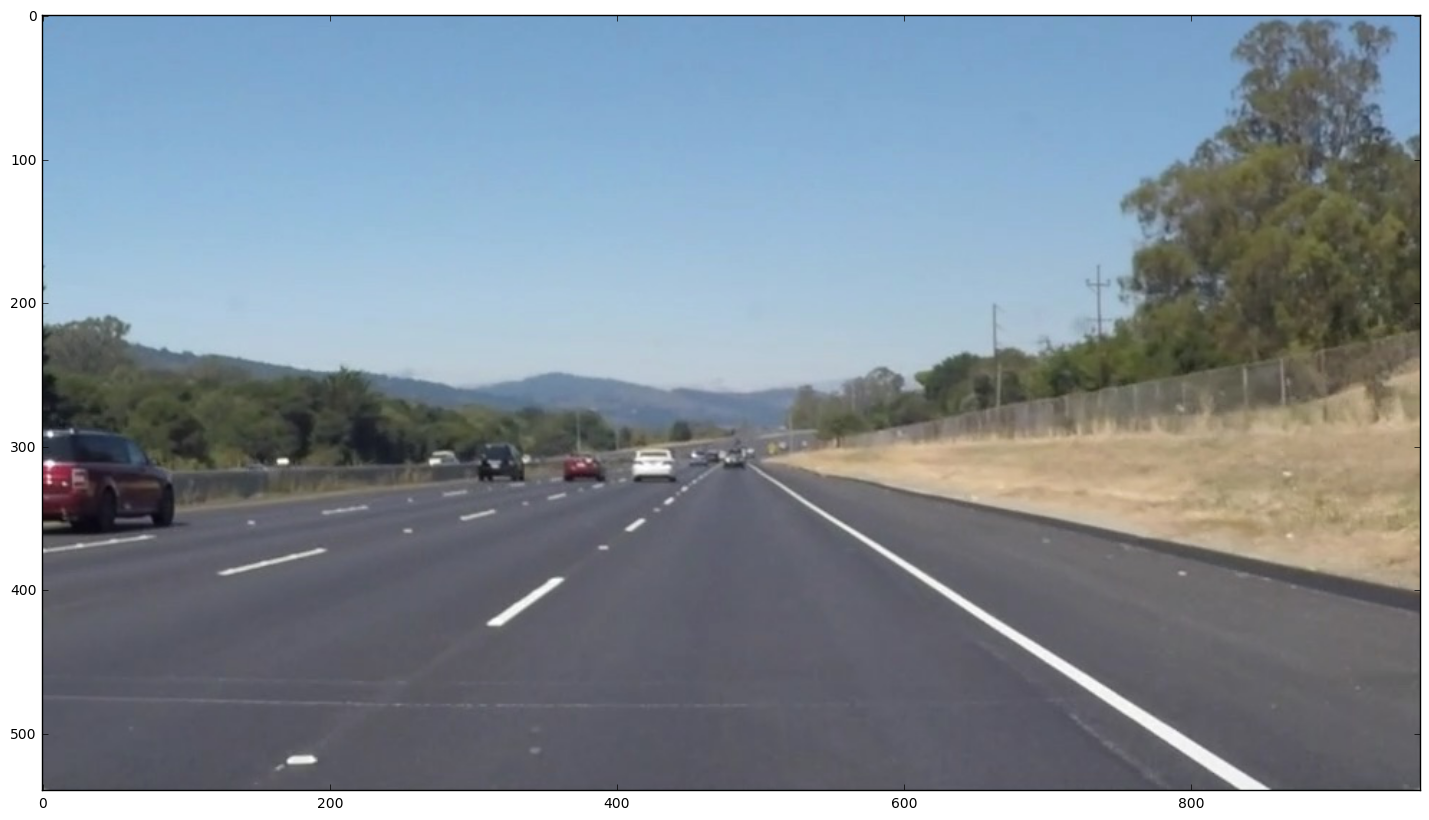

In [3]:
# Various support functions, from the classes

#import os
#os.listdir("test_images/")

#cv2.inRange() for color selection
#cv2.fillPoly() for regions selection
#cv2.line() to draw lines on an image given endpoints
#cv2.addWeighted() to coadd / overlay two images cv2.cvtColor() to grayscale or change color cv2.imwrite() to output images to file
#cv2.bitwise_and() to apply a mask to an image


#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.rcParams['figure.figsize'] = (20.0, 10.0)
#image = mpimg.imread('chall/ch-0110.jpeg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draws `lines` with `color` and `thickness`.
    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, al=0.8, be=1., ga=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, al, img, be, ga)

In [4]:
# Testing YUV and HSV colorspace for better yellow line detection
# YUV detection works better

def process_image_hsv(image):
    verticles = np.array( [[[image.shape[1]/3,image.shape[0]/5*3],[image.shape[1]-image.shape[1]/3,image.shape[0]/5*3],[image.shape[1],image.shape[0]],[0,image.shape[0]]]], dtype=np.int32 )
    region = region_of_interest(image, verticles)
    blur = cv2.GaussianBlur(region, (1, 5), 0)
    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
    lower_wh = np.array([0,0,220])
    upper_wh = np.array([255,255,255])
    mask = cv2.inRange(hsv, lower_wh, upper_wh)
#    lower_yel = np.array([85,100,100])
#    upper_yel = np.array([110,255,255])
#    mask2 = cv2.inRange(hsv, lower_yel, upper_yel)
#    mask = cv2.bitwise_or(mask,mask2)
    res = cv2.bitwise_and(image,image, mask= mask)
    gray = grayscale(res)
    imcanny = canny(gray, 150, 255)
    #imlines1 = hough_lines(imcanny, 1, np.pi/180, 20, 24, 160) #rho, theta, thresh, min_line, line_gap
    lines = cv2.HoughLinesP(imcanny, 1, np.pi/180, 20, None, minLineLength=24, maxLineGap=160)
    imlines1 = np.zeros(image.shape, dtype=np.uint8)
    draw_lines(imlines1, lines)
    image = weighted_img(imlines1,image,1,1,0.)
    return image
#plt.figure(1)
#plt.subplot(211)
#plt.imshow(imlines1)
#plt.subplot(212)
#plt.imshow(image)
#plt.show()

def process_image_yuv(image, rho=1, theta=np.pi/180, accum=16):
    verticles = np.array( [[[image.shape[1]/3,image.shape[0]/5*3],[image.shape[1]-image.shape[1]/3,image.shape[0]/5*3],[image.shape[1],image.shape[0]],[0,image.shape[0]]]], dtype=np.int32 )
    region = region_of_interest(image, verticles)
    blur = cv2.GaussianBlur(region, (1, 5), 0)
    yuv = cv2.cvtColor(blur, cv2.COLOR_BGR2YUV)
    lower_wh = np.array([200,0,0])  #lower_wh = np.array([0,0,220]) - would work but overfitted
    upper_wh = np.array([255,255,255])
    mask = cv2.inRange(yuv, lower_wh, upper_wh)
    lower_yel = np.array([0,0,0])
    upper_yel = np.array([255,100,255])
    mask2 = cv2.inRange(yuv, lower_yel, upper_yel)
    maskc = cv2.bitwise_or(mask,mask2)
    res = cv2.bitwise_and(image,image, mask= maskc)
    gray = grayscale(res)
    imcanny = canny(gray, 150, 255)
    #imlines1 = hough_lines(imcanny, 1, np.pi/180, 20, 24, 160) #rho, theta, thresh, min_line, line_gap
    lines = cv2.HoughLinesP(imcanny, rho, theta, accum, None, minLineLength=24, maxLineGap=160)
    imlines1 = np.zeros(image.shape, dtype=np.uint8)
    draw_lines(imlines1, lines)
    image = weighted_img(imlines1,image,1,1,0.)
    return image, lines
#plt.figure(1)
#plt.subplot(211)
#plt.imshow(imlines1)
#plt.subplot(212)
#plt.imshow(image)
#plt.show()

In [5]:
# In order to aggregate small lines to thicker ones, 
# I am using algorithm to merge the lines,
# by adding weighted slope m and intercept b

def process_image_yuv_weighted(image):
    #image = mpimg.imread('chall/ch-0106.jpeg')
    #image = mpimg.imread('chall/ch-0101.jpeg')
    img, lines = process_image_yuv(image)
    line_calc = np.zeros((len(lines[0]),2),dtype=float)
    line_img = np.zeros(image.shape, dtype=np.uint8)
    for i in range(len(lines[0])):
        x1 = lines[0][i][0]
        y1 = lines[0][i][1]
        x2 = lines[0][i][2]
        y2 = lines[0][i][3]
        #cv2.line(line_img, (x1, y1), (x2, y2), (255,0,0), 2)
        m = float((y2-y1))/(x2-x1)
        b = y1 - m*x1
        line_calc[i][0] = m
        line_calc[i][1] = b
    ind = np.lexsort((line_calc[:,0],line_calc[:,1]))
    line_calc = np.array(line_calc[ind][:])
    lines = np.array([lines[0][ind][:]])
    weight_del = np.zeros((len(lines[0]),2), dtype=np.uint8)
    #print line_calc
#
# Merging lines with weighted average approach
# 
    for i in range(len(line_calc)):
        if i == 0:
            #print 'zero'
            cnt = 1
            lastm = line_calc[i][0]
            lastb = line_calc[i][1]
            weight_del[i][1]=1
        else:
# This parameter determines, how much delta is allowed between line slopes so that they are merged.
            if abs((line_calc[i][0]-lastm)/line_calc[i][0])>0.4:   # TODO Find right parameter 0.05 -> 0.1
                #print 'large'
                cnt = 1
                lastm = line_calc[i][0]
                lastb = line_calc[i][1]
                weight_del[i][1]=1
            else:
                newm = (lastm*cnt+line_calc[i][0])/(cnt+1)
                newb =  (lastb*cnt+line_calc[i][1])/(cnt+1)
                #print cnt, lastm, line_calc[i][0], newm
                cnt += 1
                lastm = newm
                lastb = newb
                line_calc[i][0] = newm
                line_calc[i][1] = newb
                weight_del[i][1]=cnt
                weight_del[i-1][0]=1
    #print line_calc
    #print weight_del
    for i in range(len(line_calc)):
        if weight_del[i][0]==0 and weight_del[i][1]>1:
            m = line_calc[i][0]
            b = line_calc[i][1]
            thick = weight_del[i][1]
            y1 = int(image.shape[0])
            y2 = int(image.shape[0]/5*3)
            if m==0:
                continue
            else:
                x1 = int((y1-b)/m)
                x2 = int((y2-b)/m)
# If lines are outside of viable slope then ignore them.
# Thickness shows how probablw was the line detection
            if (m<2 and m>0.4) or (m<-0.4 and m>-2):
                cv2.line(line_img, (x1, y1), (x2, y2), (255,0,0), thick)
    
    image = weighted_img(line_img,image,1,1,0.)
    #plt.imshow(image)
    #plt.show()
    return image

#process_image_yuv_weighted(None)

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_yuv_weighted)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:06<00:00, 36.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 6.62 s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_yuv_weighted)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:18<00:00, 37.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 18.6 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
challenge_output = 'extra.mp4'
clip3 = VideoFileClip('challenge.mp4')
challenge_clip = clip3.fl_image(process_image_yuv_weighted)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:12<00:00, 20.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 13.5 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))